<h1 style="text-align: center;"><b style="color:rgb(86, 152, 217);">MIMIC III- Self-Learning Tutorial</b></h1>


<h4 style="text-align: center;"><b>Created By</b>: <b style="color:rgb(187, 141, 50);">Hemalatha Chandrasekar</b> | <b>Course</b>:<b style="color:rgb(187, 141, 50);"> AI in Healthcare(AI 395T)</b> | <b>Professor</b>: <b style="color:rgb(187, 141, 50);">Dr. Ying Ding</b></h4>

---


<h3> <b style="color:rgb(86, 152, 217);"> Summary of Segmenting Sepsis Patient using Clustering Algorithms
</b></h3>


In this Tutorial, we performed an analysis on sepsis patients using clustering algorithm. Here is a summary of the analysis:

1. Data Preparation:
    - We imported the necessary libraries, including pandas, spacy, scispacy, seaborn, and matplotlib.
    - We loaded the datasets (PATIENTS.csv, ADMISSIONS.csv, ICUSTAYS.csv, DIAGNOSES_ICD.csv) and merged them based on relevant keys.
    - We filtered the data to include only sepsis patients using ICD-9 codes.
    - We performed data preprocessing, including converting datetime columns, calculating age in years, encoding categorical variables, and selecting the final feature set.

2. Exploratory Data Analysis:
    - We visualized the distributions of age, length of stay (LOS), gender, readmission status, admission type, and mortality.
    - We used standard scaling to normalize the features.

3. Clustering:
    - We used the K-means algorithm to cluster the data into 6 clusters.
    - We used the Agglomerative Clustering algorithm with ward linkage to cluster the data into 6 clusters.
    - We evaluated the clustering results using the silhouette score.

4. Visualization:
    - We performed Principal Component Analysis (PCA) to reduce the dimensionality of the data to 3 components.
    - We visualized the clusters using scatter plots for both K-means and Agglomerative Clustering.

5. Cluster Analysis:
    - We analyzed the mean values of the clustering columns for each cluster.
    - We visualized the distributions of the clustering columns in each cluster using box plots and violin plots.

6. Entity Extraction:
    - We used Spacy and SciSpacy to extract entities from the discharge notes of sepsis patients.
    - We preprocessed the text by tokenizing, removing stopwords, lowercasing, and lemmatizing.
    - We used SciSpacy to extract entities from the preprocessed text.

7. Entity Visualization:
    - We displayed the first 15 lines of text with more than 10 words for the first 2 notes.
    - We used displacy to visualize the extracted entities in the text.

This analysis provides insights into sepsis patients and their characteristics. The clustering algorithms help identify different patient groups based on their features, and the entity extraction helps extract relevant information from the discharge notes.




In [1]:
import pandas as pd
import spacy
import scispacy
from spacy import displacy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:


# Load datasets
patients = pd.read_csv('../data/PATIENTS.csv')
admissions = pd.read_csv('../data/ADMISSIONS.csv')
icustays = pd.read_csv('../data/ICUSTAYS.csv')
diagnoses = pd.read_csv('../data/DIAGNOSES_ICD.csv')

# Optional: Display initial rows to understand the data structure
print(patients.head())
print(admissions.head())
print(icustays.head())


   ROW_ID  SUBJECT_ID GENDER                  DOB                  DOD  \
0     234         249      F  2075-03-13 00:00:00                  NaN   
1     235         250      F  2164-12-27 00:00:00  2188-11-22 00:00:00   
2     236         251      M  2090-03-15 00:00:00                  NaN   
3     237         252      M  2078-03-06 00:00:00                  NaN   
4     238         253      F  2089-11-26 00:00:00                  NaN   

              DOD_HOSP DOD_SSN  EXPIRE_FLAG  
0                  NaN     NaN            0  
1  2188-11-22 00:00:00     NaN            1  
2                  NaN     NaN            0  
3                  NaN     NaN            0  
4                  NaN     NaN            0  
   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00

In [3]:
# Merge datasets on relevant keys
df = admissions.merge(patients, on='SUBJECT_ID', how='inner')
df = df.merge(icustays, on='HADM_ID', how='inner')

# Filter for sepsis patients using ICD-9 codes (if available)
sepsis_patients = diagnoses[diagnoses['ICD9_CODE'].isin(['99591', '99592'])]
df = df[df['HADM_ID'].isin(sepsis_patients['HADM_ID'])]


In [4]:
# Uncomment to save the filtered dataset to a CSV file
# notes = pd.read_csv('../data/NOTEEVENTS.csv')
# sepsis_notes = notes[notes['HADM_ID'].isin(df['HADM_ID'])]
# sepsis_notes_discharge = sepsis_notes[sepsis_notes['CATEGORY'] == 'Discharge summary']
# sepsis_notes_discharge.to_csv('sepsis_notes_discharge.csv', index=False)

In [5]:
sepsis_notes_discharge = pd.read_csv('../data/sepsis_notes_discharge.csv')

In [6]:

# Convert to datetime
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], errors='coerce')
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')

# Calculate age in days and convert to years
df['AGE'] = (df['ADMITTIME'].astype('int64') - df['DOB'].astype('int64')) / (60 * 60 * 24 * 365.25 * 1e9)

# Encode categorical variables
df['GENDER'] = df['GENDER'].map({'M': 0, 'F': 1})
df['ADMISSION_TYPE'] = df['ADMISSION_TYPE'].isin(['EMERGENCY', 'URGENT']).astype(int)
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'], errors='coerce')
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], errors='coerce')
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds() / (24 * 60 * 60)
df['READMISSION_STATUS'] = df.sort_values(['SUBJECT_ID_x', 'ADMITTIME']) \
                                    .groupby('SUBJECT_ID_x')['ADMITTIME'] \
                                    .diff().dt.days.le(30).astype(int)

# Final feature selection
df = df[['AGE', 'LOS', 'GENDER', 'READMISSION_STATUS', 'ADMISSION_TYPE', 'HOSPITAL_EXPIRE_FLAG']]

# Select final feature set
features = df

In [7]:
clustering_cols = ['AGE', 'LOS', 'GENDER', 'READMISSION_STATUS', 'ADMISSION_TYPE', 'HOSPITAL_EXPIRE_FLAG']

In [8]:
df = df[(df['AGE'] > 0) & (df['AGE'] < 120)]
features = features[(features['AGE'] > 0) & (features['AGE'] < 120)]

# Data Visualization Summary

This section provides visualizations for the dataset using `matplotlib` and `seaborn`. It includes a histogram with KDE for age distribution, a boxplot for length of stay (LOS), and count plots for gender, readmission status, admission type, and mortality. The layout is adjusted to prevent overlap and ensure better visualization.

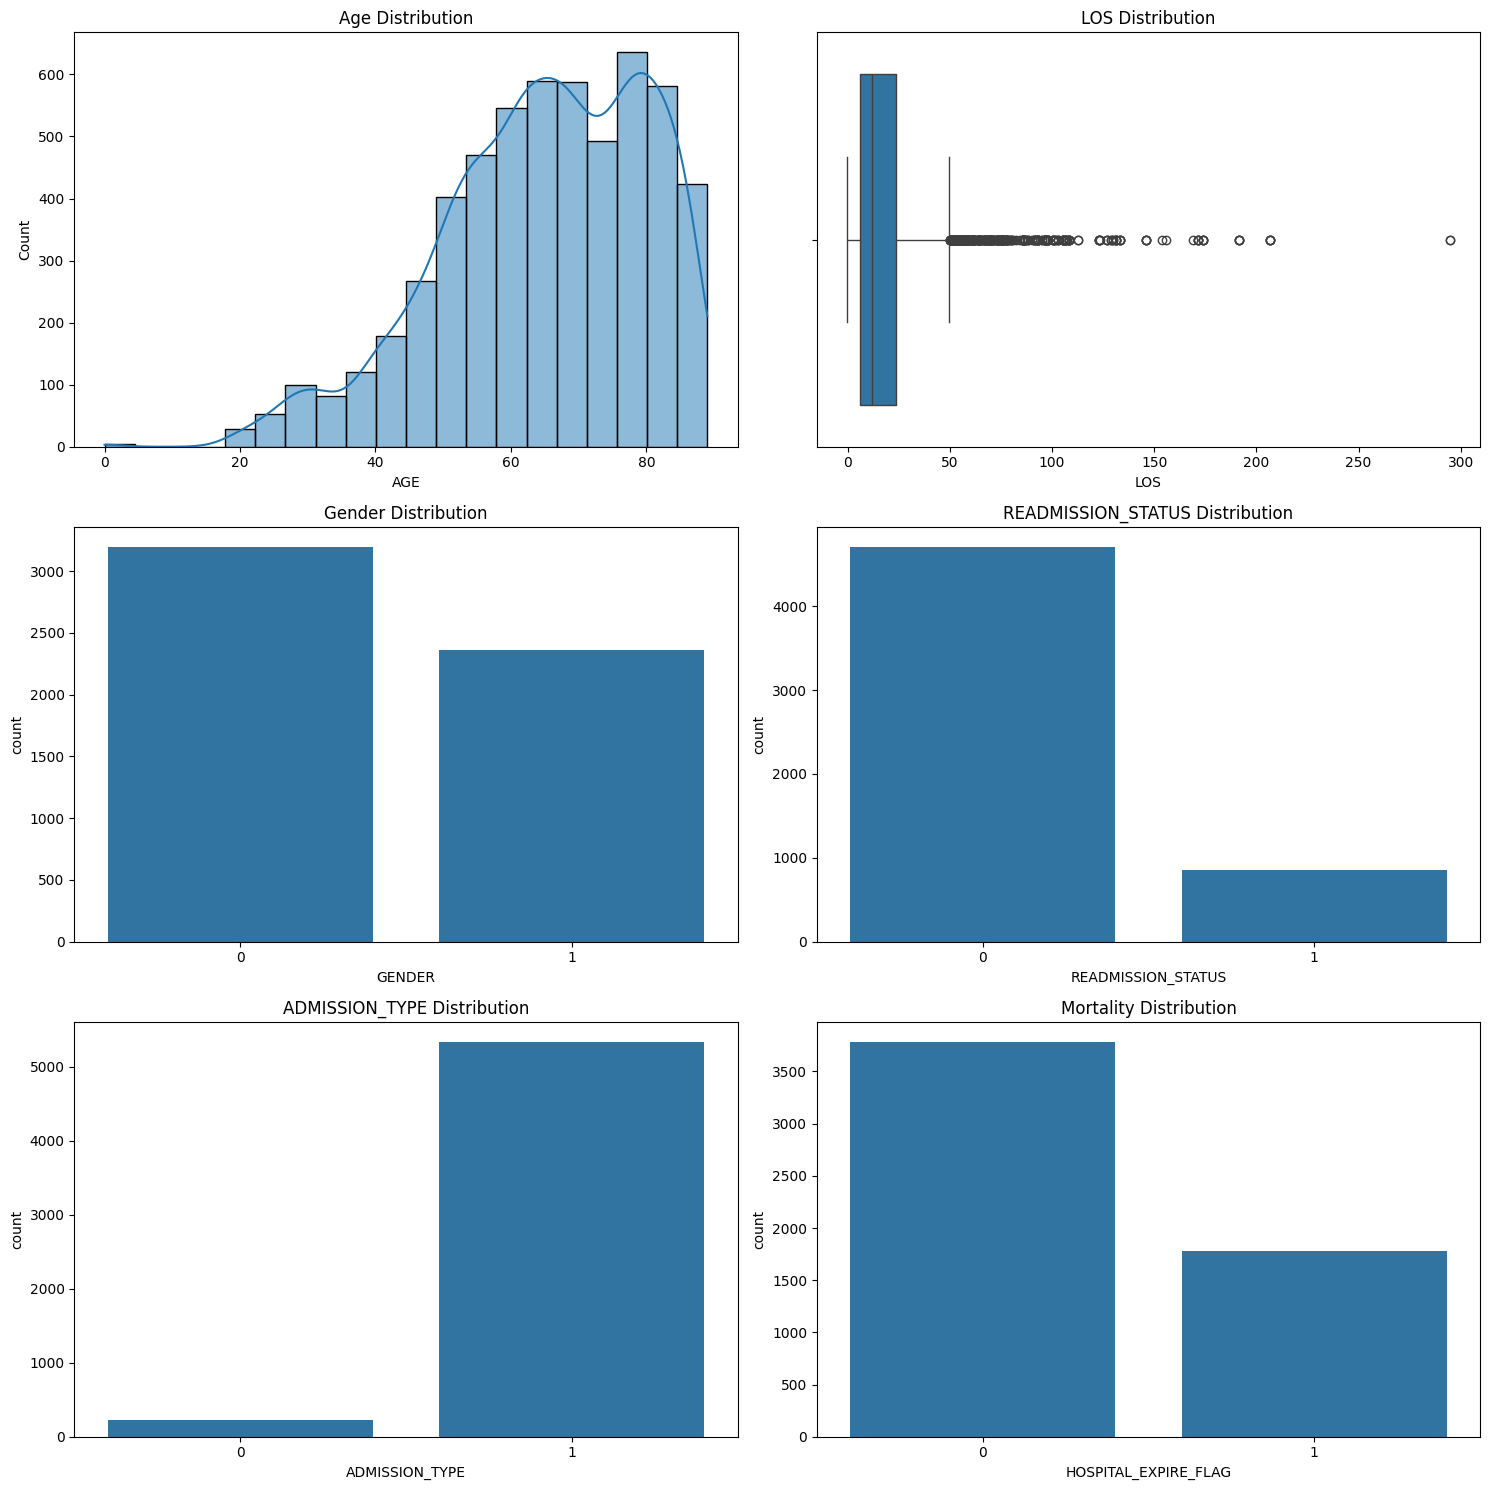

In [9]:

# Create a figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Age distribution
sns.histplot(df['AGE'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# Length of Stay (LOS) distribution
sns.boxplot(data=df, x='LOS', ax=axes[0, 1])
axes[0, 1].set_title('LOS Distribution')

# Gender distribution
sns.countplot(data=df, x='GENDER', ax=axes[1, 0])
axes[1, 0].set_title('Gender Distribution')

# READMISSION_STATUS distribution
sns.countplot(data=df, x='READMISSION_STATUS', ax=axes[1, 1])
axes[1, 1].set_title('READMISSION_STATUS Distribution')

# ADMISSION_TYPE distribution
sns.countplot(data=df, x='ADMISSION_TYPE', ax=axes[2, 0])
axes[2, 0].set_title('ADMISSION_TYPE Distribution')

# HOSPITAL_EXPIRE_FLAG distribution
sns.countplot(data=df, x='HOSPITAL_EXPIRE_FLAG', ax=axes[2, 1])
axes[2, 1].set_title('Mortality Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

## Determining the Optimal Number of Clusters

To determine the optimal number of clusters for the KMeans algorithm, we use the Elbow Method. The Elbow Method involves plotting the inertia (sum of squared distances of samples to their closest cluster center) for a range of cluster numbers and identifying the "elbow point" where the rate of decrease sharply slows down.

### Code Explanation

1. **Calculate Inertia for Different Cluster Numbers:**
   - We iterate over a range of cluster numbers (from 1 to 9).
   - For each number of clusters, we fit the KMeans algorithm to the scaled and imputed data (`X_scaled_imputed`).
   - We store the inertia for each number of clusters.

2. **Plot the Elbow Curve:**
   - We plot the number of clusters against the corresponding inertia values.
   - The plot helps to visually identify the optimal number of clusters.

### Code Implementation

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [11]:

# Impute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_scaled_imputed = imputer.fit_transform(X_scaled)


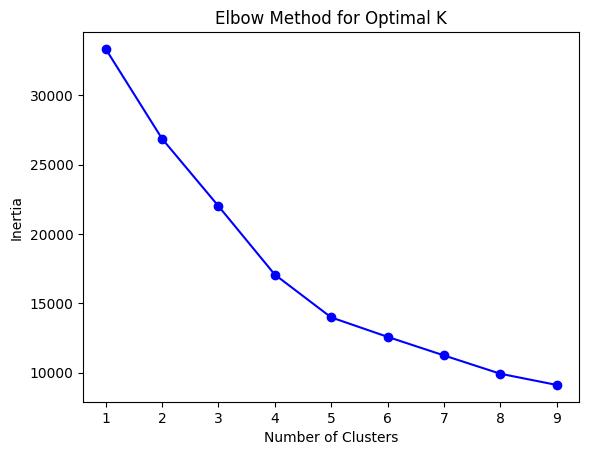

In [12]:

# Determine the optimal number of clusters
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled_imputed)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [13]:
n_clusters=6

In [14]:
from sklearn.metrics import silhouette_score

In [15]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled_imputed)

# K-Means Silhouette Score
kmeans_score = silhouette_score(X_scaled_imputed, df['kmeans_cluster'])
print(f'K-Means Silhouette Score: {kmeans_score:.2f}')


K-Means Silhouette Score: 0.35


In [16]:
from sklearn.cluster import AgglomerativeClustering

# Fit AgglomerativeClustering with appropriate parameters
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['agg_cluster'] = agg.fit_predict(X_scaled_imputed)


In [17]:

# Agglomerative Clustering Silhouette Score
agg_score = silhouette_score(X_scaled_imputed, df['agg_cluster'])
print(f'Agglomerative Clustering Silhouette Score: {agg_score:.2f}')


Agglomerative Clustering Silhouette Score: 0.41


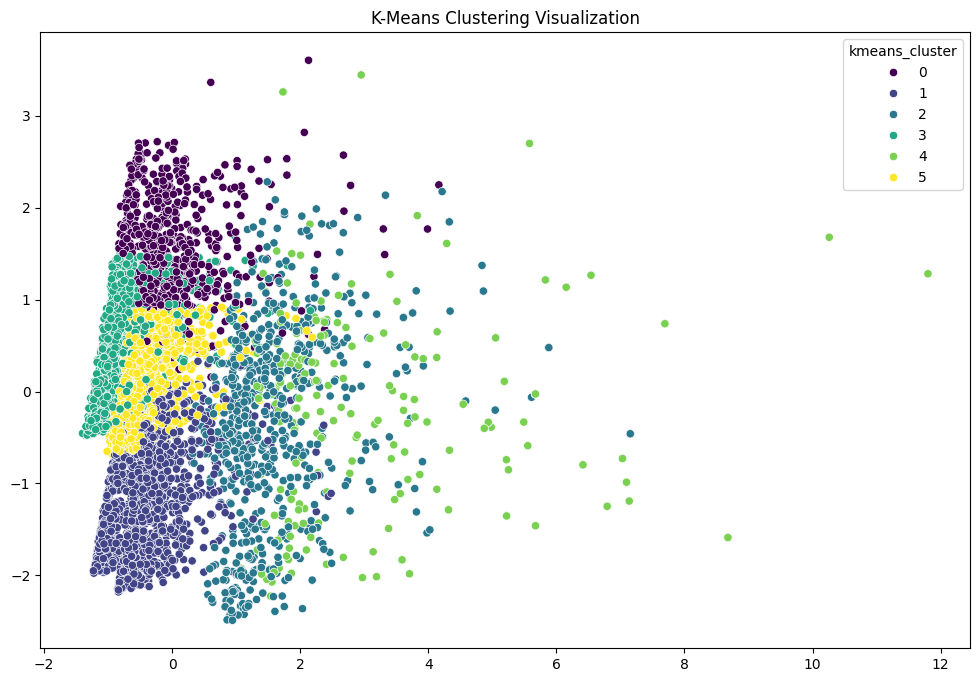

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled_imputed)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['kmeans_cluster'], palette='viridis', legend='full')
plt.title('K-Means Clustering Visualization')
plt.show()


## KMeans Clustering

| Cluster | AGE       | LOS       | GENDER | READMISSION_STATUS | ADMISSION_TYPE | HOSPITAL_EXPIRE_FLAG |
|---------|-----------|-----------|--------|--------------------|----------------|----------------------|
| 0       | 40.699500 | 20.406682 | 0.303621 | 0.000000           | 1.0            | 0.059889             |
| 1       | 68.599405 | 13.189384 | 0.420659 | 0.000000           | 1.0            | 1.000000             |
| 2       | 64.232179 | 34.804560 | 0.376263 | 0.994949           | 1.0            | 0.398990             |
| 3       | 68.760288 | 13.805038 | 1.000000 | 0.000000           | 1.0            | 0.000000             |
| 4       | 64.842281 | 46.432605 | 0.334821 | 0.294643           | 0.0            | 0.370536             |
| 5       | 71.192358 | 14.341528 | 0.000000 | 0.000000           | 1.0            | 0.000000             |


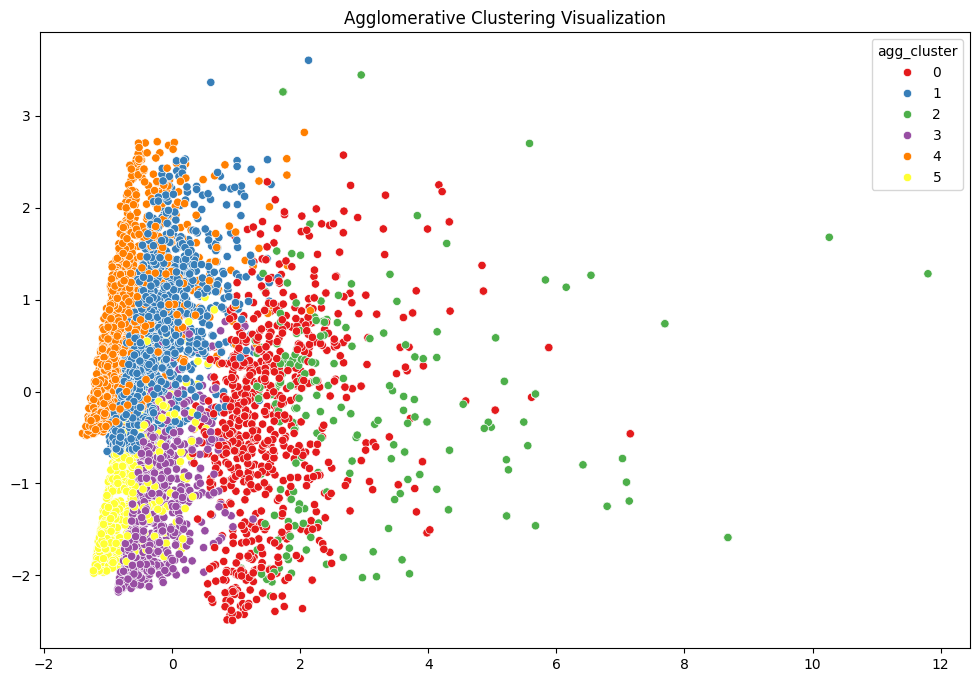

In [19]:

# Perform PCA for visualization purposes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled_imputed)

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agg_clustering.fit_predict(X_scaled_imputed)

# Add the cluster labels to the DataFrame
df['agg_cluster'] = clusters

# Visualize the clustering results
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['agg_cluster'], palette='Set1', legend='full')
plt.title('Agglomerative Clustering Visualization')
plt.show()

## Agglomerative Clustering

| Cluster | AGE       | LOS       | GENDER | READMISSION_STATUS | ADMISSION_TYPE | HOSPITAL_EXPIRE_FLAG |
|---------|-----------|-----------|--------|--------------------|----------------|----------------------|
| 0       | 63.833102 | 37.787816 | 0.374262 | 0.930342           | 1.0            | 0.422668             |
| 1       | 63.876804 | 15.412773 | 0.000000 | 0.000000           | 1.0            | 0.000000             |
| 2       | 64.842281 | 46.432605 | 0.334821 | 0.294643           | 0.0            | 0.370536             |
| 3       | 67.144983 | 12.411642 | 0.000000 | 0.000000           | 1.0            | 1.000000             |
| 4       | 64.054302 | 14.395101 | 1.000000 | 0.000000           | 1.0            | 0.000000             |
| 5       | 68.275897 | 10.903002 | 1.000000 | 0.000000           | 1.0            | 1.000000             |


In [20]:
# Analyze K-Means clusters
print(df.groupby('kmeans_cluster')[clustering_cols].mean())

# Analyze Agglomerative clusters
print(df.groupby('agg_cluster')[clustering_cols].mean())

#print(df.groupby('kmeans_cluster')[['insurance_Private', 'marital_status_Married']].sum())

                      AGE        LOS    GENDER  READMISSION_STATUS  \
kmeans_cluster                                                       
0               40.699500  20.406682  0.303621            0.000000   
1               68.599405  13.189384  0.420659            0.000000   
2               64.232179  34.804560  0.376263            0.994949   
3               68.760288  13.805038  1.000000            0.000000   
4               64.842281  46.432605  0.334821            0.294643   
5               71.192358  14.341528  0.000000            0.000000   

                ADMISSION_TYPE  HOSPITAL_EXPIRE_FLAG  
kmeans_cluster                                        
0                          1.0              0.059889  
1                          1.0              1.000000  
2                          1.0              0.398990  
3                          1.0              0.000000  
4                          0.0              0.370536  
5                          1.0              0.000000  

In [21]:

# Function to visualize distributions in clusters
def visualize_clusters(df, cluster_col, clustering_cols, palette):
    for col in clustering_cols:
        plt.figure(figsize=(10, 6))
        if df[col].nunique() > 10:  # Assuming continuous variables have more than 10 unique values
            sns.boxplot(x=cluster_col, y=col, data=df, palette=palette)
            plt.title(f'{col} Distribution in {cluster_col} Clusters')
        else:  # Assuming categorical variables have 10 or fewer unique values
            sns.violinplot(x=cluster_col, y=col, data=df, palette=palette)
            plt.title(f'{col} Distribution in {cluster_col} Clusters')
        plt.show()

# Define color palettes
kmeans_palette = sns.color_palette("viridis", n_colors=df['kmeans_cluster'].nunique())
agg_palette = sns.color_palette("Set1", n_colors=df['agg_cluster'].nunique())


In [22]:
clustering_cols

['AGE',
 'LOS',
 'GENDER',
 'READMISSION_STATUS',
 'ADMISSION_TYPE',
 'HOSPITAL_EXPIRE_FLAG']

### Gender Distribution for Clustering algorithm
The gender distribution for the clustering algorithm is visualized using box plots and violin plots. These plots provide insights into how gender is distributed across different clusters for both K-Means and Agglomerative Clustering algorithms.

- **K-Means Clustering**:
    - The violin plot provides a detailed view of the gender distribution, highlighting the density and probability of gender values within each cluster.

- **Agglomerative Clustering**:
    - Similar to K-Means, the plot and violin plot illustrate the gender distribution across the clusters.

The visualizations reveal patterns and differences in gender distribution among the clusters, aiding in the interpretation of clustering results and their implications for sepsis patient management.

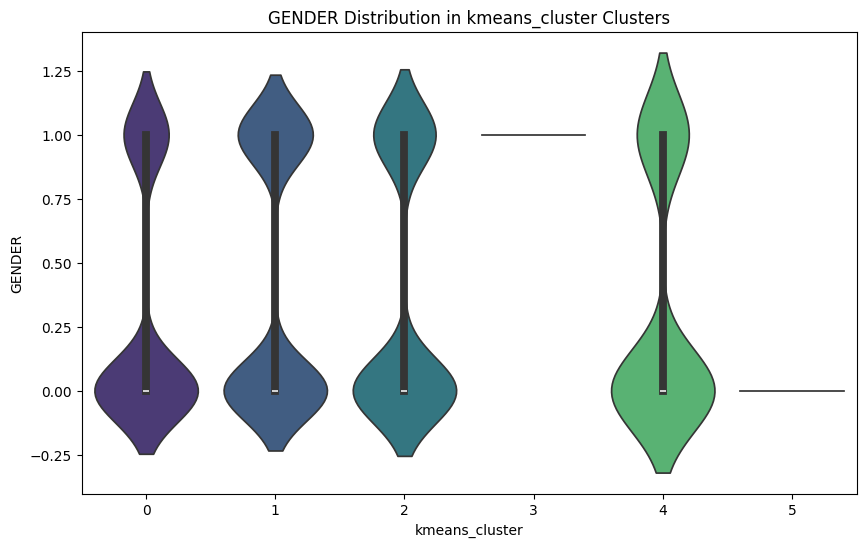

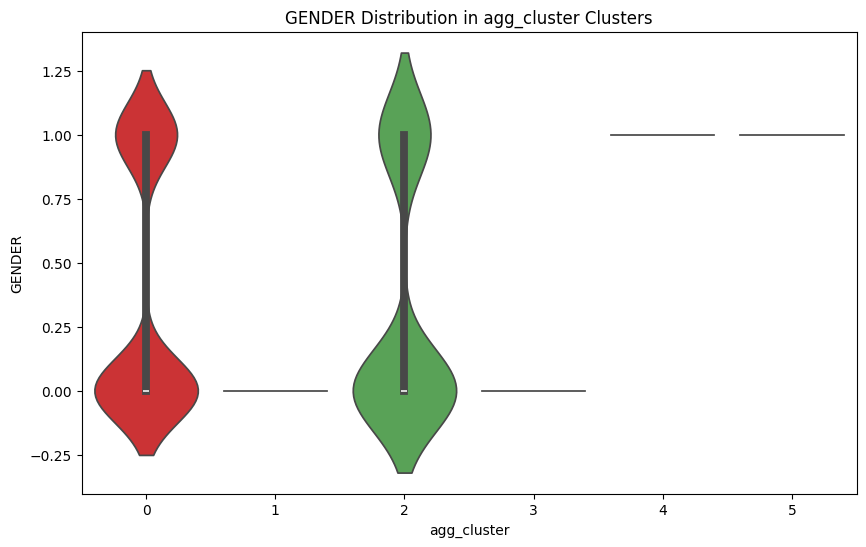

In [23]:

feature = ['GENDER']
# Visualize K-Means clusters
visualize_clusters(df, 'kmeans_cluster', feature, kmeans_palette)

# Visualize Agglomerative clusters
visualize_clusters(df, 'agg_cluster', feature, agg_palette)

### Age distribution for clustoring algorithm
The age distribution for the clustering algorithm is visualized using box plots and violin plots. These plots provide insights into how age is distributed across different clusters for both K-Means and Agglomerative Clustering algorithms.

- **K-Means Clustering**:
    - The box plot provides a detailed view of the age distribution, highlighting the median, quartiles, and potential outliers within each cluster.

- **Agglomerative Clustering**:
    - Similar to K-Means, the box plot and violin plot illustrate the age distribution across the clusters.

The visualizations reveal patterns and differences in age distribution among the clusters, aiding in the interpretation of clustering results and their implications for sepsis patient management.

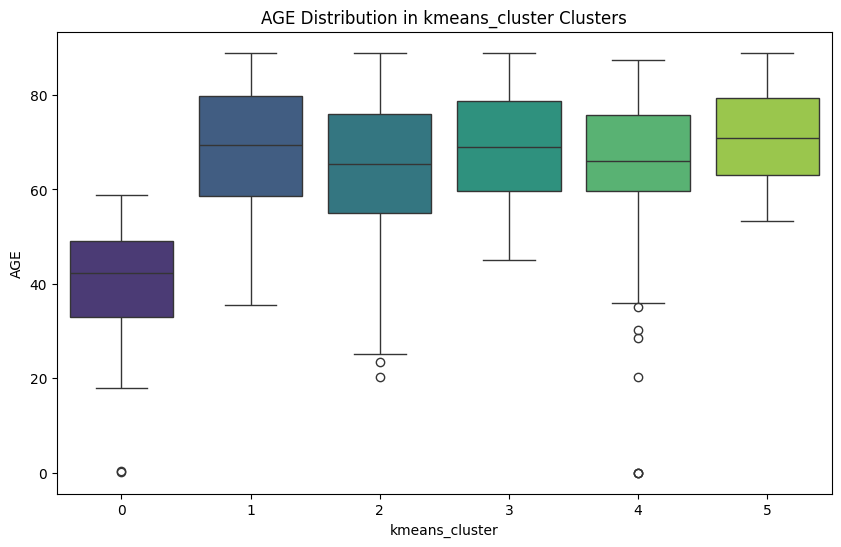

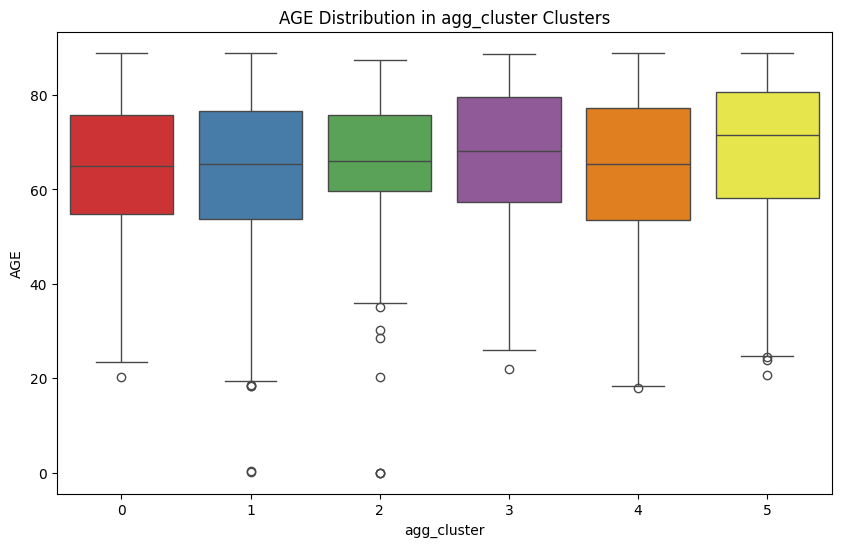

In [24]:

feature = ['AGE']
# Visualize K-Means clusters
visualize_clusters(df, 'kmeans_cluster', feature, kmeans_palette)

# Visualize Agglomerative clusters
visualize_clusters(df, 'agg_cluster', feature, agg_palette)

### Length of Stay distribution
The length of stay (LOS) distribution for the clustering algorithm is visualized using box plots and violin plots. These plots provide insights into how LOS is distributed across different clusters for both K-Means and Agglomerative Clustering algorithms.

- **K-Means Clustering**:
    - The box plot provides a detailed view of the LOS distribution, highlighting the median, quartiles, and potential outliers within each cluster.

- **Agglomerative Clustering**:
    - Similar to K-Means, the box plot and violin plot illustrate the LOS distribution across the clusters.

The visualizations reveal patterns and differences in LOS distribution among the clusters, aiding in the interpretation of clustering results and their implications for sepsis patient management.

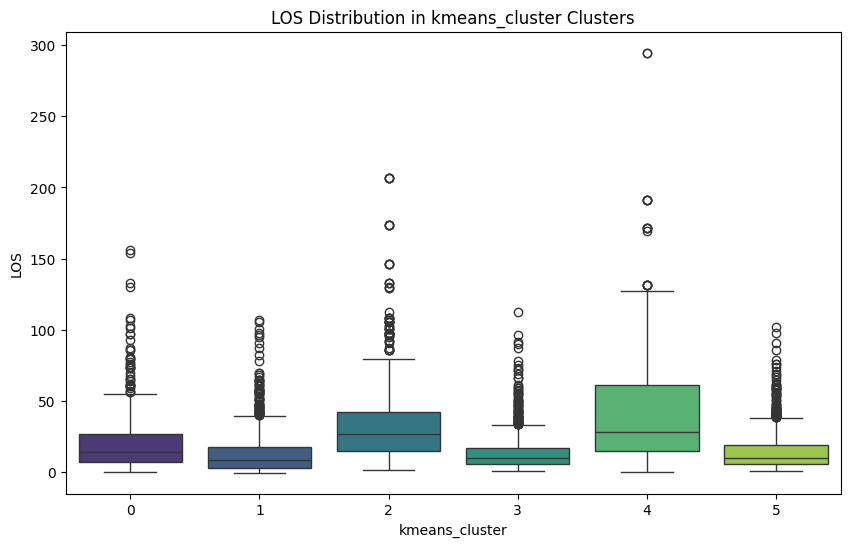

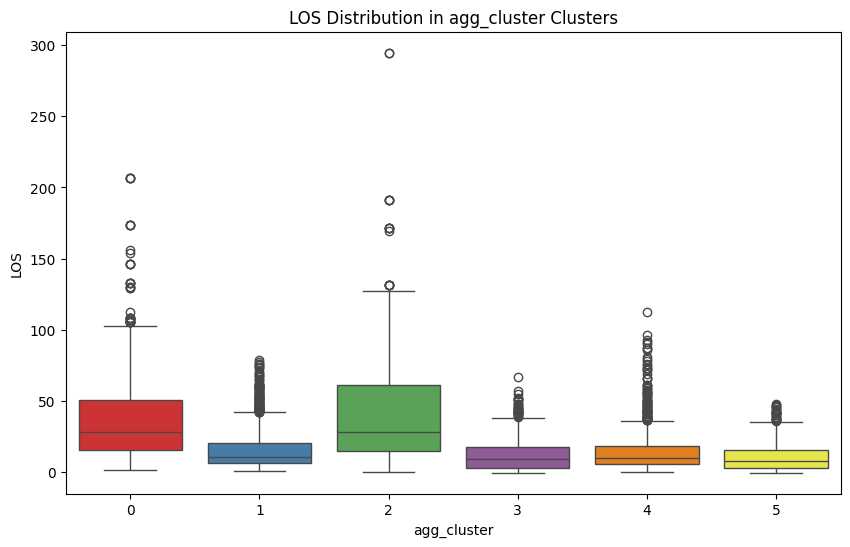

In [25]:

feature = ['LOS']
# Visualize K-Means clusters
visualize_clusters(df, 'kmeans_cluster', feature, kmeans_palette)

# Visualize Agglomerative clusters
visualize_clusters(df, 'agg_cluster', feature, agg_palette)

### Mortality distribution of clustering
To visualize the mortality distribution across different clusters for both K-Means and Agglomerative Clustering algorithms, we use violin plots. These plots provide insights into how the hospital expire flag (mortality) is distributed across the clusters.

- **K-Means Clustering**:
    - The violin plot provides a detailed view of the mortality distribution, highlighting the median, quartiles, and potential outliers within each cluster.

- **Agglomerative Clustering**:
    - Similar to K-Means, the violin plot illustrate the mortality distribution across the clusters.

The visualizations reveal patterns and differences in mortality distribution among the clusters, aiding in the interpretation of clustering results and their implications for sepsis patient management.

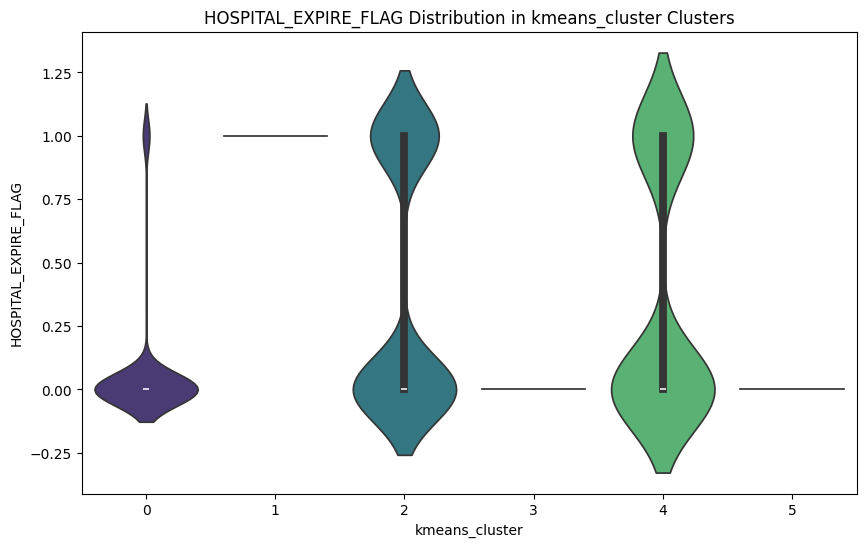

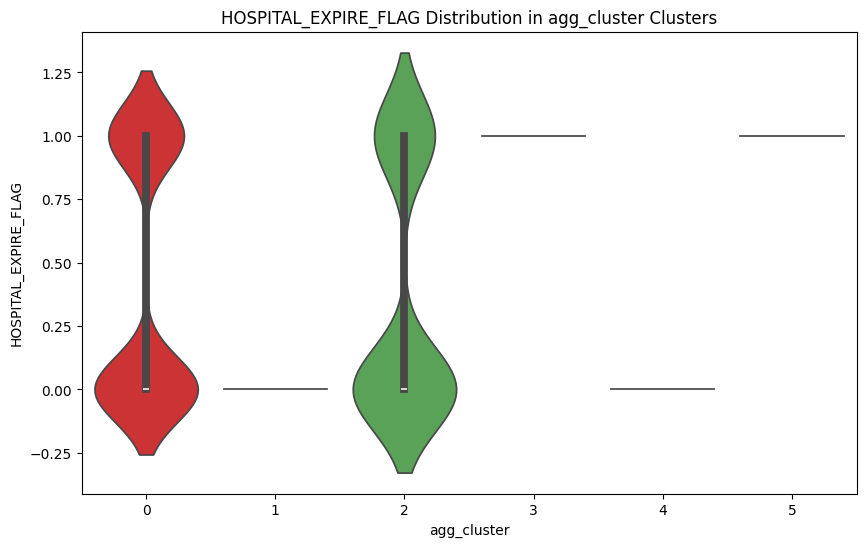

In [26]:

feature = ['HOSPITAL_EXPIRE_FLAG']
# Visualize K-Means clusters
visualize_clusters(df, 'kmeans_cluster', feature, kmeans_palette)

# Visualize Agglomerative clusters
visualize_clusters(df, 'agg_cluster', feature, agg_palette)

### Entity Extraction using Spacy and SciSpacy for Sepsis Patient
Entity extraction was performed using both Spacy and SciSpacy to analyze the discharge notes of sepsis patients. The process involved several steps:

1. **Loading Models**:
    - Spacy's `en_core_web_sm` model was used for general NLP tasks.
    - SciSpacy's `en_core_sci_lg` model was used for extracting medical entities.

2. **Data Preprocessing**:
    - The discharge notes were filtered to include only those containing the term "sepsis".
    - Text preprocessing included tokenization, removing stopwords, lowercasing, and lemmatization.

3. **Entity Extraction**:
    - Entities were extracted from the preprocessed text using SciSpacy.
    - The extracted entities were labeled with their respective types (e.g., diseases, symptoms).

4. **Visualization**:
    - Spacy's `displacy` was used to visualize the extracted entities in the text.

This analysis provided insights into the medical terminology and entities present in the discharge notes of sepsis patients, aiding in better understanding and management of their conditions.

In [27]:
nlp = spacy.load('en_core_web_sm')

In [28]:
sepsis_notes_discharge_sample = sepsis_notes_discharge.head(500)

In [29]:
sepsis_notes_discharge_sample.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,236,26601,116471.0,2127-07-30,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2127-7-21**] ...
1,237,26601,155131.0,2131-12-29,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2131-12-23**] ...
2,240,27051,113012.0,2194-02-02,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2194-1-7**] D...
3,221,75347,152030.0,2174-06-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2174-5-3**] D...
4,2,23224,117806.0,2154-05-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2154-4-30**] ...


In [30]:
sepsis_notes_discharge_sample = sepsis_notes_discharge_sample[sepsis_notes_discharge_sample['TEXT'].str.contains('sepsis', case=False, na=False)]

In [31]:
# Preprocess: tokenization, removing stopwords, lowercasing, lemmatization
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

sepsis_notes_discharge_sample['cleaned_text'] = sepsis_notes_discharge_sample['TEXT'].apply(preprocess)

In [32]:
# Load SciSpacy model
nlp_scispacy = spacy.load("en_core_sci_lg")

# Extract entities with SciSpacy
def extract_scispacy_entities(text):
    doc = nlp_scispacy(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

sepsis_notes_discharge_sample['scispacy_entities'] = sepsis_notes_discharge_sample['cleaned_text'].apply(extract_scispacy_entities)
# Print entities
sepsis_notes_discharge_sample[['cleaned_text', 'scispacy_entities']].head()


,cleaned_text,scispacy_entities
0,admission date 2127 7 21 disch...,"[(admission, ENTITY), (amiodarone, ENTITY), (q..."
1,admission date 2131 12 23 disc...,"[(admission, ENTITY), (amiodarone, ENTITY), (q..."
2,admission date 2194 1 7 discha...,"[(admission, ENTITY), (patient record, ENTITY)..."
3,admission date 2174 5 3 discha...,"[(admission, ENTITY), (sex, ENTITY), (ciproflo..."
4,admission date 2154 4 30 disch...,"[(admission, ENTITY), (sex, ENTITY), (rigor, E..."


In [33]:
# Function to get the first 15 lines of text with more than 10 words each
def get_first_valid_lines(text, min_words=10, num_lines=15):
    lines = text.split('\n')
    valid_lines = [line for line in lines if len(line.split()) > min_words]
    return '\n'.join(valid_lines[:num_lines])

# Process and display the first 15 lines of text with more than 10 words for the first 2 notes
for i in range(2):
    text = sepsis_notes_discharge_sample['cleaned_text'].iloc[i]
    first_valid_lines = get_first_valid_lines(text, min_words=10, num_lines=15)
    doc = nlp_scispacy(first_valid_lines)
    displacy.render(doc, style='ent', jupyter=True)

---


### Summary Insights

By comparing the K-Means and Agglomerative clustering results, we can derive the following insights:

1. **Age Distribution**:
    - Both clustering methods identify clusters with older patients, typically above 60 years of age.
    - The average age across clusters is relatively consistent between the two methods.

2. **Length of Stay (LOS)**:
    - Both methods identify clusters with varying LOS, from short (around 10-15 days) to very long (over 45 days).
    - Clusters with very long LOS (Cluster 4 in both methods) have similar characteristics, indicating a consistent pattern.

3. **Gender Distribution**:
    - Both methods identify clusters with 100% female or 0% female, indicating strong gender-based clustering.
    - The percentage of female patients in mixed-gender clusters is also similar between the two methods.

4. **Readmission Status**:
    - High readmission rates are consistently observed in clusters with long LOS.
    - Clusters with 0% readmission rates are typically those with shorter LOS.

5. **Admission Type**:
    - Both methods identify clusters predominantly characterized by elective admissions.
    - Emergency admissions are less frequent but are consistently identified in specific clusters (Cluster 4).

6. **Hospital Expire Flag**:
    - High hospital mortality is observed in specific clusters (Cluster 1 in K-Means and Cluster 3 in Agglomerative).
    - Clusters with 0% hospital mortality are also consistently identified, typically those with shorter LOS and elective admissions.

Overall, both clustering methods provide consistent insights into patient demographics, LOS, readmission rates, and hospital mortality, with minor variations in cluster composition.

<h1>Conclusion</h1>

Based on our analysis, we gained valuable insights into sepsis patients and their characteristics. The clustering algorithms helped identify different patient groups based on their features, and the entity extraction provided relevant information from the discharge notes. This analysis can contribute to better understanding and management of sepsis patients in healthcare settings.

Further analysis and exploration can be done to dive deeper into the clusters and entities extracted, enabling more targeted interventions and personalized care for sepsis patients.
